In [64]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import csv

In [65]:
# import augmented Dickey-Fuller test (adfuller), Ljung-Box statistic (q_stat), autocorrelation function (acf)
# ARMA class that can be fit and used for predicting; arma_order_select_ic for choosing the ARMA parameters
from statsmodels.tsa.stattools import adfuller, q_stat, acf, ARMA, arma_order_select_ic
# import functions for statistical testing
from scipy.stats import normaltest
# import preprocessing for normalization
from sklearn import preprocessing

### Step 1: getting the data and cleaning it up

In this step we do the following:

1. Get the OHLC data from the AlphaVantage
2. Explore the data
3. Clean up some mistakes and transform the data

In [3]:
# read my AlphaVantage API key
APIkey = open("AlphaVantage API key").read().splitlines()[0]

In [4]:
ticker='ISP.MI'                  #user specified company ticker
outsize='full'               #output size. "full" goes up to 20 yrs back. "compact" goes 100 datapoints back.
UrlDailyData=('https://www.alphavantage.co/query?function=TIME_SERIES_DAILY'
              +'&symbol='+ticker
              +'&outputsize='+outsize
              +'&apikey='+APIkey+'&datatype=csv')  #constructing API call using ticker and personal API key
DailyTimeSeries=pd.read_csv(UrlDailyData)            #reading data in csv format via API

In [5]:
# expplore the dataframe
DailyTimeSeries.head(5)

,timestamp,open,high,low,close,volume
0,2019-11-28,2.3200,2.3250,2.2970,2.3100,64034958
1,2019-11-27,2.3440,2.3470,2.3275,2.3275,62688089
2,2019-11-26,2.3490,2.3535,2.3320,2.3420,82290353
3,2019-11-25,2.3565,2.3635,2.3425,2.3525,41444685
4,2019-11-22,2.3595,2.3715,2.3390,2.3435,77801082


In [6]:
# take last 100 days
close = DailyTimeSeries['close'][0:1000]

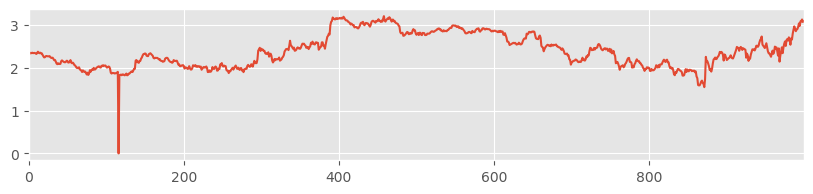

In [7]:
# plot the close prices
plt.style.use('ggplot')
plt.figure(figsize=(10,2), dpi=100)
close.plot()

In [8]:
# reorder the series so that later times are to the right
close = close.iloc[::-1].reset_index(drop=True)

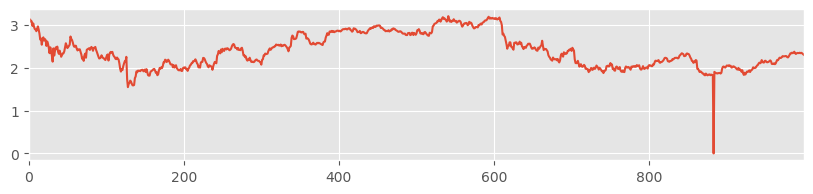

In [9]:
# visualize results
plt.figure(figsize=(10,2), dpi=100)
close.plot()

In [19]:
# find the corrupt data point
close[close<1]

883    0.0
Name: close, dtype: float64

In [31]:
# save the index of the outlier
outlier_index = close[close<1].index.tolist()[0]
# explore the values of the nearby data points
close[outlier_index-2 : outlier_index+3]

881    1.8374
882    1.8310
883    0.0000
884    1.9072
885    1.5732
Name: close, dtype: float64

In [32]:
# fix the corrupt data point, by taking the average of the  nearby points
# (less lazy approach would be to find this data from another source, but let's say one data point is not so relevant)
close.iloc[outlier_index] = (close.iloc[outlier_index-2]/2 + close.iloc[outlier_index-1] + close.iloc[outlier_index+1] + close.iloc[outlier_index+2]/2)/3

In [33]:
# verify that the data is fixed now
close[outlier_index-1 : outlier_index+2]

882    1.8310
883    1.8145
884    1.9072
Name: close, dtype: float64

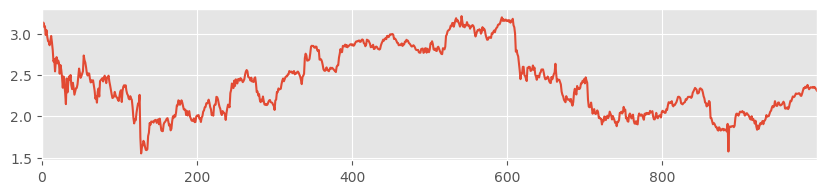

In [34]:
# visualize results
plt.figure(figsize=(10,2), dpi=100)
close.plot()

### Step 2: analyzing the series

In this step we do the following:
1. Test the series for stationarity (ADF test)
2. Test the hypothesis that the autocorrelation function (ACF) vanishes (Ljung-Box test)
3. Explore the ACF to try to guess the class of the ARMA model that might describe the series

In [35]:
# get log returns
log_ret = np.log(close/close.shift(1))
log_ret = log_ret.dropna()

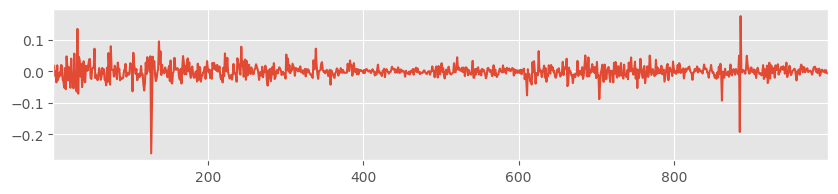

In [36]:
# plot results
plt.figure(figsize=(10,2), dpi=100)
log_ret.plot()

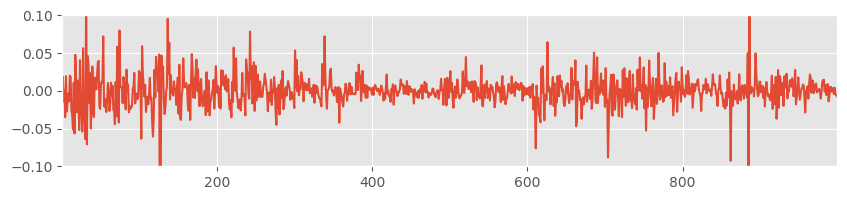

In [37]:
plt.figure(figsize=(10,2), dpi=100)
plt.ylim(-.1,.1)
log_ret.plot()

In [16]:
# it would appear from the above plot that the variance is not time invariant, meaning that the series is NOT stationary
# estimate by performing augmented Dickey-Fuller test:
ADF_results = adfuller(log_ret, autolag='BIC')

print(f"ADF statistic is {ADF_results[0]:.2f}. The corresponding p-value is {ADF_results[1]:.3f}.")
print("Confidence levels and their corresponding critical values are:")
for key,value in ADF_results[4].items():
    print(f"{key}: {value:.3f}")

ADF statistic is -31.24. The corresponding p-value is 0.000.
Confidence levels and their corresponding critical values are:
1%: -3.437
5%: -2.864
10%: -2.568


In [17]:
# ADF test null hypothesis is that the series is non-stationary
# we can reject it if p-value is <0.05
# p-value came out to be incredibly small, based on which the null-hypothesis can be rejected
# in fact, comparing the statistic to the critical values, it is clear that the null-hypothesis can be rejected even at 1% confidence level

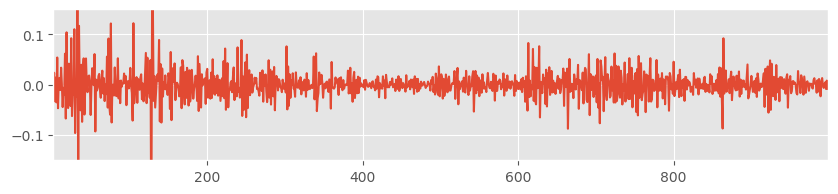

In [18]:
#get the differenced series, to estimate whether ARIMA would be more appropriate
log_ret_diff = log_ret.diff()
log_ret_diff = log_ret_diff.dropna()
# plot results
plt.figure(figsize=(10,2), dpi=100)
plt.ylim(-.15,.15)
log_ret_diff.plot()

In [19]:
# the above plot again shows signs of volatility clustering - differencing didn't help much
# use ADF test again to test for stationarity:
ADF_results = adfuller(log_ret_diff)

print(f"ADF statistic is {ADF_results[0]:.2f}. The corresponding p-value is {ADF_results[1]:.3f}.")
print("Confidence levels and their corresponding critical values are:")
for key,value in ADF_results[4].items():
    print(f"{key}: {value:.3f}")

ADF statistic is -11.95. The corresponding p-value is 0.000.
Confidence levels and their corresponding critical values are:
1%: -3.437
5%: -2.864
10%: -2.568


In [88]:
# the above result confirms that the differenced series is stationary as well
# let us explore autocorrelation functions before fitting an ARMA model to the returns series
# begin by computing the Ljung-Box statistic
Q_statistic = q_stat(log_ret, len(log_ret))

In [106]:
# null-hypothesis is that all the lag-l ACFs up to given l are zero.
# resulting p-values are quite large, therefore we conclude that the null-hypothesis cannot be rejected,
# in fact, all autocorrelations appear to be compatible with zero.

for i in range(10):
    print(f"for lag {i}, Q-statistic is {Q_statistic[0][i]:.3f}. Corresponding p-value is {Q_statistic[1][i]:.2f}.")

for lag 0, Q-statistic is 0.010. Corresponding p-value is 0.92.
for lag 1, Q-statistic is 0.037. Corresponding p-value is 0.98.
for lag 2, Q-statistic is 0.388. Corresponding p-value is 0.94.
for lag 3, Q-statistic is 0.589. Corresponding p-value is 0.96.
for lag 4, Q-statistic is 0.589. Corresponding p-value is 0.99.
for lag 5, Q-statistic is 1.818. Corresponding p-value is 0.94.
for lag 6, Q-statistic is 2.192. Corresponding p-value is 0.95.
for lag 7, Q-statistic is 2.947. Corresponding p-value is 0.94.
for lag 8, Q-statistic is 3.240. Corresponding p-value is 0.95.
for lag 9, Q-statistic is 3.252. Corresponding p-value is 0.97.


See [this page](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html#statsmodels.tsa.stattools.acf) for the documentation for the following block.


In [140]:
# let us compute the autocorrelation function. 
# by setting qstat to TRUE we also (re-)compute the Ljung-Box
# by setting alpha we get confidence intervals (based on Bartlett's formula)
returns_acf = acf(log_ret, nlags=30, alpha=.05, qstat=True)

/home/vskrin/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [141]:
autocorr, conf_int, _, _ = returns_acf

In [145]:
for i in range(6):
    print(f"ACF at lag {i} is: {autocorr[i]:.3f}. 95% confidence interval is: {conf_int[i]}")

ACF at lag 0 is: 1.000. 95% confidence interval is: [1. 1.]
ACF at lag 1 is: 0.010. 95% confidence interval is: [-0.05178968  0.07223135]
ACF at lag 2 is: 0.004. 95% confidence interval is: [-0.05822779  0.0658062 ]
ACF at lag 3 is: -0.021. 95% confidence interval is: [-0.08351732  0.04051845]
ACF at lag 4 is: -0.069. 95% confidence interval is: [-0.13071505 -0.00662197]
ACF at lag 5 is: -0.012. 95% confidence interval is: [-0.07405023  0.05062594]


In [135]:
range(len(acf))

range(0, 11)

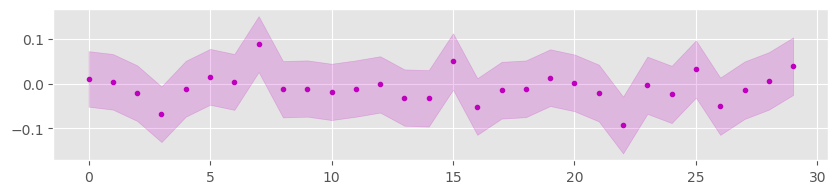

In [182]:
plt.figure(figsize=(10,2), dpi=100)
plt.plot(autocorr[1:], 'm.')
plt.fill_between(range(0,30), conf_int[1:,0], conf_int[1:,1], color='m', alpha=.2)

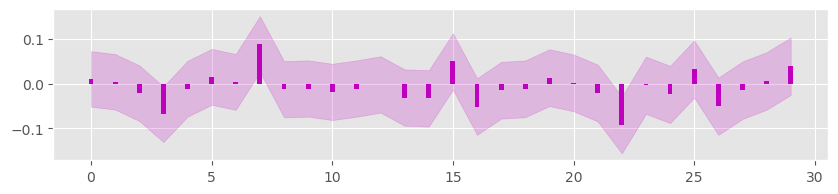

In [183]:
plt.figure(figsize=(10,2), dpi=100)
plt.bar(range(len(autocorr)-1), autocorr[1:], width=.2, color='m')
plt.fill_between(range(0,30), conf_int[1:,0], conf_int[1:,1], color='m', alpha=.2)

The above plot (in two different visual representations) shows that almost all autocorrelations are compatible with zero at 95% confidence level (only two being barely non-zero at this confidence).

We take it from this that the series does not show any significant autocorrelations.

Depending on their roots, AR models would have exponentially damping or oscillating ACFs - no sign of which can be seen here. MA(q) models have non-zero lag-l autocorrelations for l<=q and zero otherwise. Again, no sign of such behavior can be witnessed here.

Nonetheless, let us see what insisting on fitting an ARMA model would produce:

In [187]:
#evaluate different ARMA processes
# AR order given in rows, MA order given in columns
#results given for different information criteria
arma_order_select_ic(log_ret, max_ar=3, max_ma=3, ic=["aic", "bic"])

{'aic':              0            1            2            3
 0 -4820.235576 -4818.339032 -4816.359497 -4814.754603
 1 -4818.339848 -4816.341900 -4814.375632 -4814.321505
 2 -4816.353396 -4820.058369 -4817.949896 -4814.239121
 3 -4814.817827 -4814.558921 -4816.737427 -4822.939800,
 'bic':              0            1            2            3
 0 -4810.422067 -4803.618767 -4796.732477 -4790.220829
 1 -4803.619584 -4796.714880 -4789.841858 -4784.880976
 2 -4796.726377 -4795.524595 -4788.509367 -4779.891838
 3 -4790.284053 -4785.118392 -4782.390143 -4783.685762,
 'aic_min_order': (3, 3),
 'bic_min_order': (0, 0)}

Bayesian Information Criterion, BIC, which usually gives more parsimonious models than Akaike Information Criterion, AIC, turned out to prefer the ARMA(0,0) model, as expected.
Note that in the above ACF plots there's a shift of the lag by 1 (e.g. x=0 corresponds to lag=1). The result of the AIC could be interpreted as the lowest order for which the ACF is quantitatively different from zero to some significance degree. This choice does not have good support, obviously.

From the above discussion we might expect the price series to be a geometrical Brownian motion. In this case the log prices would have a Gaussian distribution. We test for this next. The rest of this comment is a brief review of the theory taken from Tsay, "Financial Time Series", section 6.4.

Let $\mu$ and $\sigma$, also known as drift and volatility, be two constants. Let $w_t$ be a Wiener process. Then, by definition, the process $$ dP_t = \mu P_t dt + \sigma P_t dw_t $$ is a geometric Brownian motion. Assume that the stock price follows such motion, then the log of the price follows a generalized Wiener process,
$$ dln(P_t) = (\mu-\frac{\sigma^2}{2})dt + \sigma dw_t $$ From discretizing this process, it follows that $$log(P_{t1})-log(P_{t2}) \sim \mathcal{N}\left((\mu-\frac{\sigma^2}{2})(t1-t2),\ \sigma^2(t1-t2)\right)$$

In [46]:
#compute log price differences (at lag 1, i.e. t1-t2=1 in the above formula)
log_price = np.log(close)
log_diff = (log_price/log_price.shift(1)).dropna()

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.16784156,  0.        ,  0.        ,  0.16784156,  0.        ,
         0.        ,  0.33568312,  0.50352467,  0.16784156,  0.33568312,
         0.83920779,  2.01409869,  2.34978181,  2.01409869,  4.69956361,
         5.87445451,  7.38502853, 14.26653239, 16.44847264, 25.17623364,
        26.68680765, 20.81235314, 10.23833501,  5.87445451,  6.21013763,
         3.69251427,  2.34978181,  2.51762336,  0.67136623,  0.83920779,
         0.83920779,  0.67136623,  0.83920779,  1.00704935,  0.        ,
         0.        ,  0.16784156,  0.33568312,  0.16784156,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([0.85 , 0.856, 0.862, 0.868, 0.874, 0.88 , 0.886, 0.892, 0.898,
        0.904, 0.91 , 0.916, 0.922, 0.928, 0.934, 0.94 , 0.946, 0.952,
        0.958, 0.964, 0.97 , 0.976, 0.982, 0.988, 0.994, 1.   , 1.006,
        1.012, 1.018, 1.024, 1.03 , 1.036, 1.042, 1.048

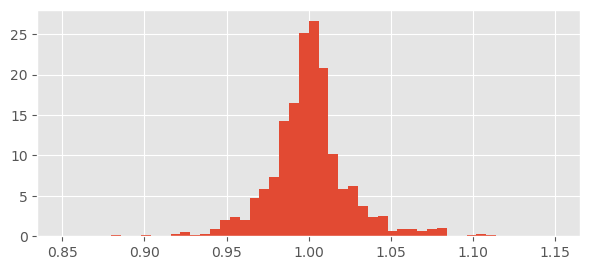

In [61]:
#plot the distribution of the time series
plt.figure(figsize=(7,3), dpi=100)
plt.hist(log_diff, range=(0.85,1.15), bins=50, density=True)

(array([0.        , 0.00629406, 0.        , 0.        , 0.        ,
        0.00629406, 0.        , 0.        , 0.        , 0.01888218,
        0.01258812, 0.00629406, 0.        , 0.03147029, 0.06294058,
        0.05035247, 0.0755287 , 0.06294058, 0.13217523, 0.20770393,
        0.23288016, 0.3335851 , 0.43429003, 0.66087613, 0.88746224,
        0.79305136, 0.67346425, 0.41540785, 0.31470292, 0.17623364,
        0.13846928, 0.13217523, 0.0755287 , 0.10070493, 0.01258812,
        0.03776435, 0.01888218, 0.03147029, 0.01258812, 0.03147029,
        0.03147029, 0.00629406, 0.        , 0.        , 0.00629406,
        0.01888218, 0.        , 0.        , 0.        , 0.        ]),
 array([-4.  , -3.84, -3.68, -3.52, -3.36, -3.2 , -3.04, -2.88, -2.72,
        -2.56, -2.4 , -2.24, -2.08, -1.92, -1.76, -1.6 , -1.44, -1.28,
        -1.12, -0.96, -0.8 , -0.64, -0.48, -0.32, -0.16,  0.  ,  0.16,
         0.32,  0.48,  0.64,  0.8 ,  0.96,  1.12,  1.28,  1.44,  1.6 ,
         1.76,  1.92,  2.08,  2.24

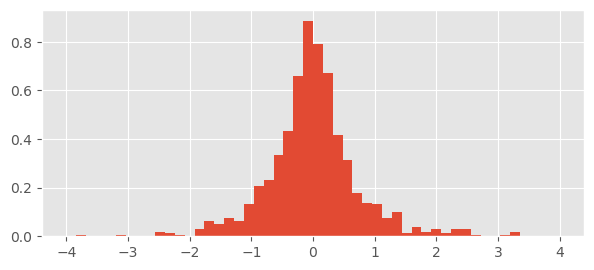

In [100]:
# if the data is distributed according to a Gaussian distribution, we can safely transform it to a normal distro for the testing
norm_data = (log_diff - np.mean(log_diff))/np.std(log_diff)
#plot the distribution of the standardized time series
plt.figure(figsize=(7,3), dpi=100)
plt.hist(norm_data, range=(-4,4), bins=50, density=True)

In [102]:
#this histogram is clearly "bell shaped". to test if it is well-described by a normal distribution, we perform a normality test
# (this is necessary as skewness and excess kurtosis cannot be judged from the figure alone)
normaltest(log_diff)

NormaltestResult(statistic=344.82282066382874, pvalue=1.326404161241866e-75)

z-score is incredibly large and p value is extremely small, significantly below any meaningful threshold. From the results we conclude that the null hypothesis can be rejected. Null hypothesis of the used test (D'Agostino-Pearson) is that the data is generated by a normal distro. Therefore, we conclude that the distribution is **not Gaussian**.

In [103]:
#note that the same result of the test would be obtained on the standardized data (since the test performs the standardization itself)
normaltest(norm_data)

NormaltestResult(statistic=344.82282066382857, pvalue=1.3264041612419793e-75)

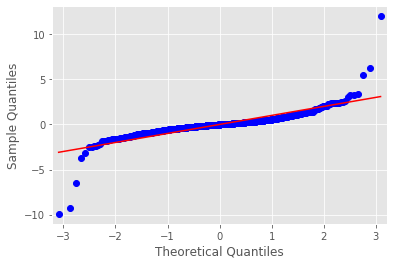

In [117]:
# finally, we peform a QQ-plot in order to better evaluate the non-normality
# the most prominent departure from the normal quantiles are the very heavy tails
# we can see that there is not much skewness
fig = sm.qqplot(norm_data, line='s')